In [ ]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

In [ ]:
from template_funciones import *

# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [ ]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

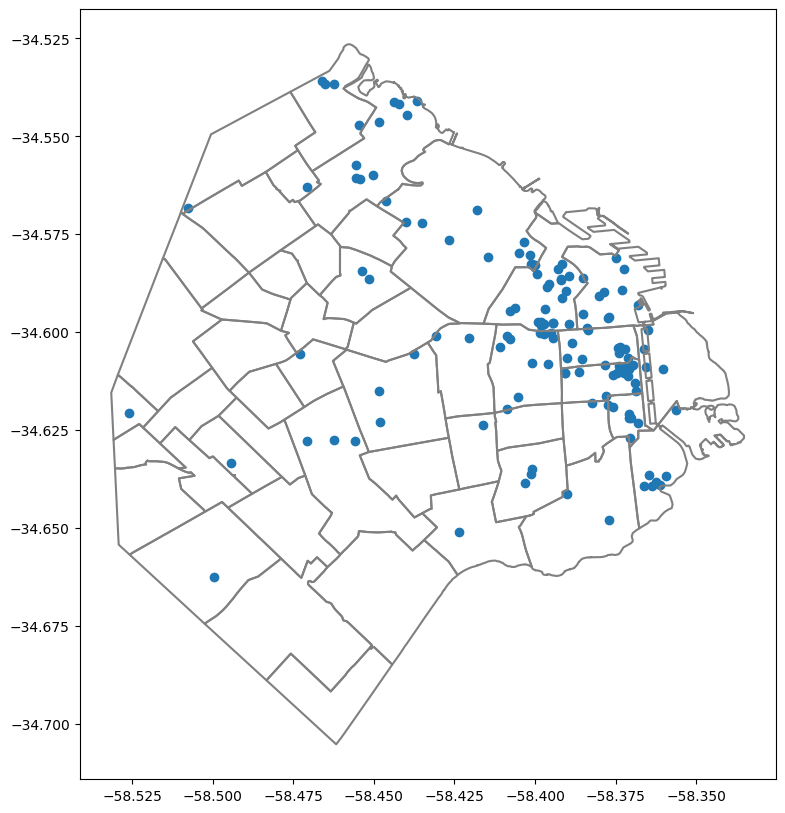

In [ ]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [ ]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()

### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [ ]:
m = 3 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [ ]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

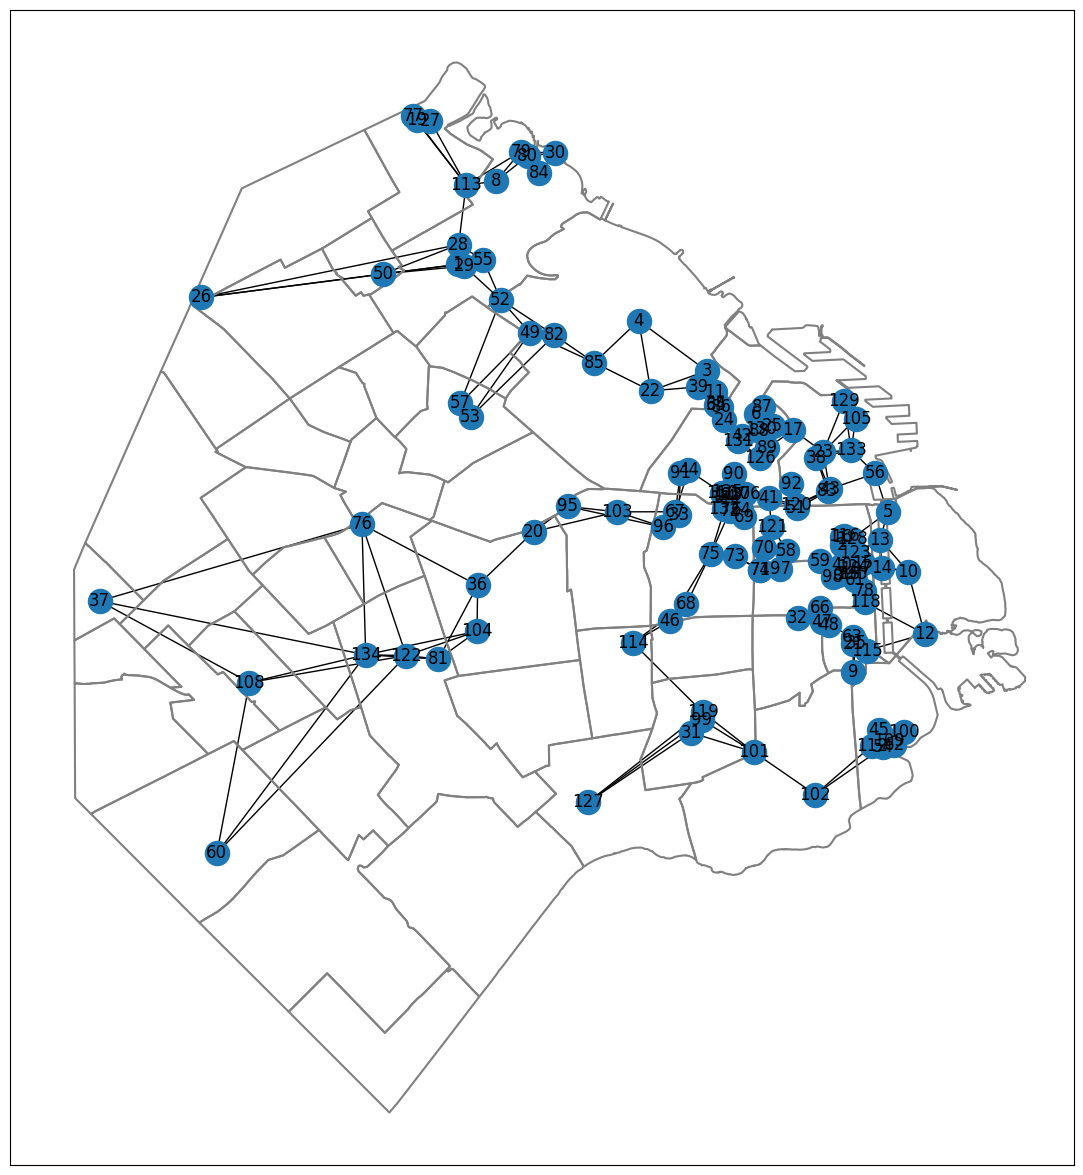

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP

Aquí empieza la aventura... ¡diviertanse y consulten lo que necesiten!

## Punto 1:

Inicialmente, contamos con la siguiente ecuación:

$\mathbf{p} = (1 - \alpha) \ C \ \mathbf{p} + \frac{\alpha}{N} \mathbf{1}$

Nuestro objetivo es poder demostrar que el vector de rankings **p** es solución de la siguiente ecuación:

$M \ \mathbf{p} = \mathbf{b}$

Teniendo a:

$M = \frac{N}{\alpha} \left( I - (1 - \alpha) C \right)$ \
$\mathbf{b} = 1$ \
$ α \neq 0 $ pues de lo contrario $M$ se indefine ($\text{Observación}:$
si $α = 0 → p$ es solución de $p = Cp$)

Para ello, realizamos los siguientes pasos, logrando así llegar el resultado deseado:

\

$\mathbf{p} =(1−α) C \mathbf{p} \ + \ \frac{α}{N} \mathbf{1}$   &nbsp; &nbsp; partimos de esta ecuación.

\

$\mathbf{p} - (1−α) C \mathbf{p} \ = \ \frac{α}{N} \mathbf{1}$ &nbsp; &nbsp; pasamos lo que involucra a $p$ del lado izquierdo de la igualdad.

\

$ (I -(1−α) C ) \mathbf{p} \ = \ \frac{α}{N} \mathbf{1}$ &nbsp; &nbsp; sacamos de factor común $p$ (Nota: $I p \ = p$).

\

$ (I -(1−α) C ) \mathbf{p} \  \frac{N}{α} = \mathbf{1}$ &nbsp; &nbsp; pasamos $\frac{α}{N}$ del otro lado de la igualdad (Nota: $\frac{α}{N}$ es un escalar, &nbsp;$ α \neq 0 $ ).

\

$ \frac{N}{α} \ (I -(1−α) C ) \mathbf{p} \ = \mathbf{1}$  &nbsp; &nbsp; al ser escalar, no importa si $\frac{N}{α}$ está al principio o al final.

\

$ M \mathbf{p} \ = \ \mathbf{1}$ &nbsp; &nbsp; lo que acompañaba a $\mathbf{p}$ es lo que, previamente, se definió como $M$.

\

$M \mathbf{p} \ = \ \mathbf{b} $ &nbsp; &nbsp; pues $\mathbf{b}$ estaba definida como $\mathbf{1}$, quedando demostrado que $\mathbf{p}$ es solución de lo pedido.


\


 $\hspace{15cm}  \huge\boxtimes $

## Punto 2:


Para que exista una única solución a la ecuación del punto anterior, debe ocurrir que el sistema sea **SCD (Sistema Compatible Determinado)**.
Teniendo un sistema genérico $Mx = b$, esto ocurre sí y solo sí $M$ es cuadrada ($M \in \mathbb{K}^{n \times n}) $ con $det(M) \neq 0 $ , lo cual sucede únicamente si $M$ es inversible (se puede pensar como que el rango de la matriz pre y post triangulación es el mismo, esto es, $\ \text{rk}(M) = n$). En definitiva, llegamos a que:\
$Mx = b \ \iff \ M \ es \ inversible$

Veamos si se cumplen estas condiciones para la matriz $M$ tal como fue construida para los museos, cuando $0 < α < 1$ .

Si logramos ver que $(I -(1-α) C)$ es inversible, entonces $ \frac{N}{α} \ (I -(1−α) C )$ lo será también.

\

($\text{Obs:} \ sea \ A \in \mathbb{K}^{n \times n}, \lambda \in \mathbb{K} \rightarrow det(\lambda A) = \lambda ^n * det (A)$.

Por lo tanto, $\ det(\frac{N}{α} \ (I -(1−α) C ) = \ (\frac{N}{α} )^n * det((I -(1−α) C ) \ $ y como $ \frac{N}{α} \neq 0 $ basta con que $(I -(1−α) C )$ sea inversible).



\

Para la demostración, sin embargo, usaremos la siguiente propiedad:

$\textbf{Propiedad: } \ \text{sea } \ v \in \mathbb{K}^n, \quad ||v||_1 = 0 \iff v = \vec{0}$.

\

En conjunto con esta definición:

$\textbf{Definición:} \quad || \ .  ||_1 =
\max\limits_{1 \leq j \leq n} \left( \sum_{i=1}^n {|A_{ij}|} \right)$

\

Dicho esto, $(I -(1-α) C)$ es inversible $\iff \ ∀v \in \mathbb{K}^n \setminus \{\vec{0}\} \Rightarrow (I -(1-α) C)v \neq \vec{0} $

Supongamos que no se cumple. Es decir, planteemos que $∃v \neq \vec{0} : (I - (1 - α)C)v = \vec{0}\ $. Luego :

$ Iv - (1 - α)Cv = \vec{0} $

$ v - (1 - α)C v = \vec{0}$

$ v = (1 - α)C v$

Luego, al ser iguales, entonces, en particular, su $||\  . ||_1$ será equivalente:

$ ||v||_1 = ||(1 - α)C v||_1 $

Como $ || \ . ||_ 1 \ $ es norma, se tiene que $\ ∀w \in \mathbb{K}^n, \ ∀ λ \in \mathbb{K} \quad ||λw||_1 = |λ|*||w||_1  $

Por lo tanto, como $(1 - α)$ es un escalar, y teniendo en cuenta que $ 0 < α < 1 \rightarrow 0 < 1 - α < 1 $, la ecuación queda:

$ ||v||_1 = (1 - α)||C v||_1 $


\

Como $||\ .||_1$ es norma, entonces se tiene que $ \ ||Cv||_1 \leq ||C||_1*||v||_1$.

Pero al ser $C$ estocástica, esto significa que sus columnas suman 1. Y usando la definición vista, entonces podemos afirmar que:

$ \ ||Cv||_1 \leq ||C||_1* ||v||_1 = 1 *||v||_1 = ||v||_1$

\

En nuestra ecuación, esto se traduce en que:

$ ||v||_1 \leq (1 - α)||v||_1 $

\

Pero $|| \ . ||_1 : \mathbb{V} → \mathbb{R} \geq 0$ con $\mathbb{V}$ espacio vectorial.

Por la propiedad descripta anteriormente, como $v \neq \vec{0} → ||v||_1 \neq 0 ; \ $ y puesto que $0 < 1 - α < 1 \ $, entonces la ecuación finalmente queda:

$ 1 \leq (1 - α) \ ABS \ $; donde el absurdo provino de suponer que existía vector no nulo que cumpla lo pedido.


En definitiva, $\ \nexists v \in \mathbb{K}^n \setminus \{ \vec{0} \} :  (I -(1−α) C )v = \vec{0}$

\

$ \therefore (I -(1−α) C ) \ \text{es inversible} ⇒ \ M = \frac{N}{α}(I - (1 - α)C) \ \text{es inversible}$

$\hspace{22cm}  \huge\boxtimes $


## Punto 3:

El puntaje del museo 0 es 0.0035629688116857483
El puntaje del museo 1 es 0.014411010823626919
El puntaje del museo 2 es 0.009227796205364267
El puntaje del museo 3 es 0.004305714750476433
El puntaje del museo 4 es 0.0030766429338145314
El puntaje del museo 5 es 0.003357163952992011
El puntaje del museo 6 es 0.01447440634845583
El puntaje del museo 7 es 0.006158458520696581
El puntaje del museo 8 es 0.0027290820634473887
El puntaje del museo 9 es 0.0014705882352941176
El puntaje del museo 10 es 0.0026630067688404872
El puntaje del museo 11 es 0.011567859933486725
El puntaje del museo 12 es 0.0014705882352941176
El puntaje del museo 13 es 0.0030759670944494506
El puntaje del museo 14 es 0.003000981265504768
El puntaje del museo 15 es 0.003866853601103972
El puntaje del museo 16 es 0.009227796205364267
El puntaje del museo 17 es 0.0025855493445569823
El puntaje del museo 18 es 0.021280854967728868
El puntaje del museo 19 es 0.003151260504201681
El puntaje del museo 20 es 0.00438920043802

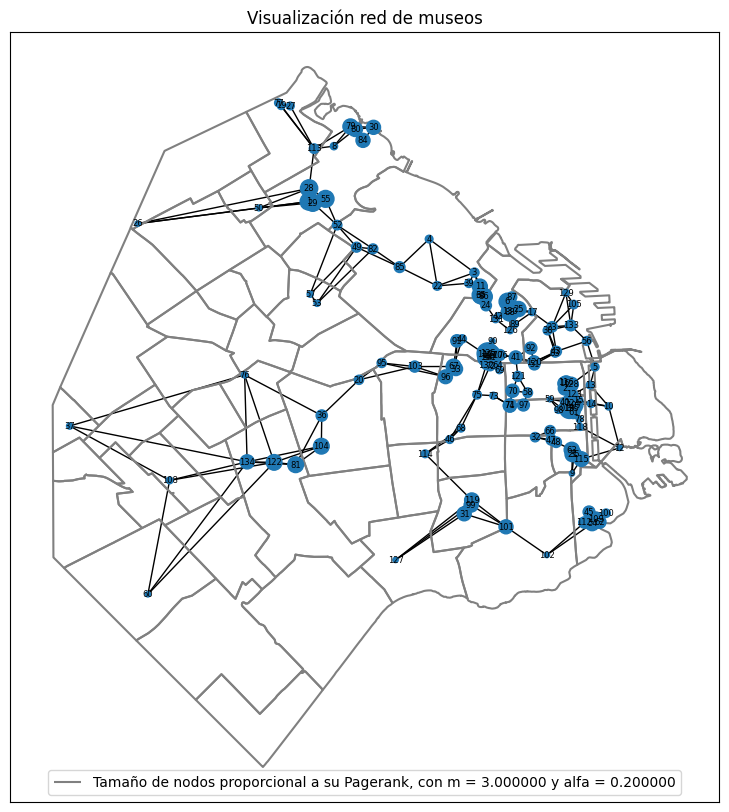

In [ ]:
#Punto 3 primer item a

#Construcción matriz de adyacencia.
A = construye_adyacencia(D,3)

#la siguiente función recibe una matriz de adyacencia y un factor de amortiguamiento
puntajes_a = calcula_pagerank(A, 1/5)

#la siguiente función imprime el Page Rank de cada museo en pantalla
mostrar_pagerank(puntajes_a)
m = 3
alfa = 1/5

"""Red de museos, donde cada uno se conecta con sus m = 3 vecinos más cercanos y con factor de
amortiguamiento α = 1/5, asignando un tamaño a cada nodo proporcional al Page Rank que le toca."""
graficoA = grafico(m, alfa)

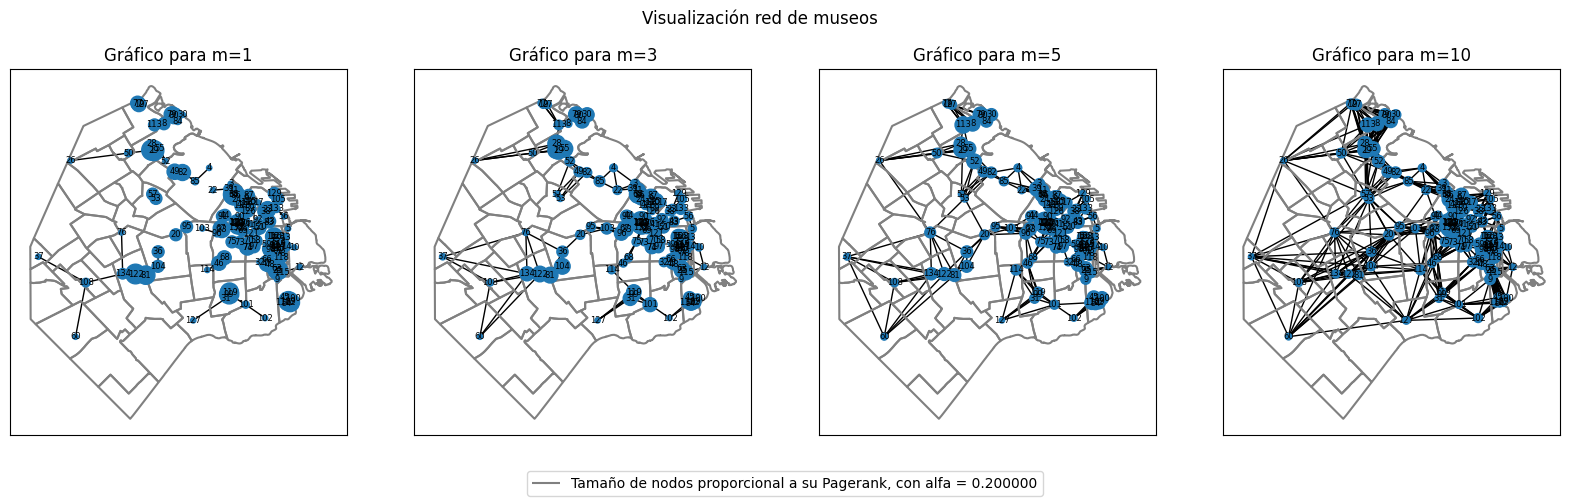

In [ ]:
#Punto 3 item b + visualizaciones pedidas en el segundo ítem b
M = [1,3,5,10]
alfa = 0.2

#La función recibe una matriz de adyacencia y un factor de amortiguamiento (alfa)
#Calcula los Page Rank para cada cantidad de enlaces (m) solicitada
puntaje_b1 = calcula_pagerank(construye_adyacencia(D, 1), alfa)
puntaje_b2 = calcula_pagerank(construye_adyacencia(D, 3), alfa)
puntaje_b3 = calcula_pagerank(construye_adyacencia(D, 5), alfa)
puntaje_b4 = calcula_pagerank(construye_adyacencia(D, 10), alfa)

#Si se desea visualizar los Page Rank obtenidos de los museos en cada caso, se recomienda el uso de la función mostrar_pagerank, implementada en el archivo template_funciones.py
#mostrar_pagerank(puntaje_b1)
#mostrar_pagerank(puntaje_b2)
#mostrar_pagerank(puntaje_b3)
#mostrar_pagerank(puntaje_b4)


"""Red de museos, donde cada uno se conecta con sus m vecinos mas cercanos, para m = {1, 3, 5, 10} y
con factor de amortiguamiento fijo usando α = 1/5, asignando un tamaño a cada nodo proporcional al
Page Rank que le toca"""
agrupar_graficos_variacion_m(M, alfa)

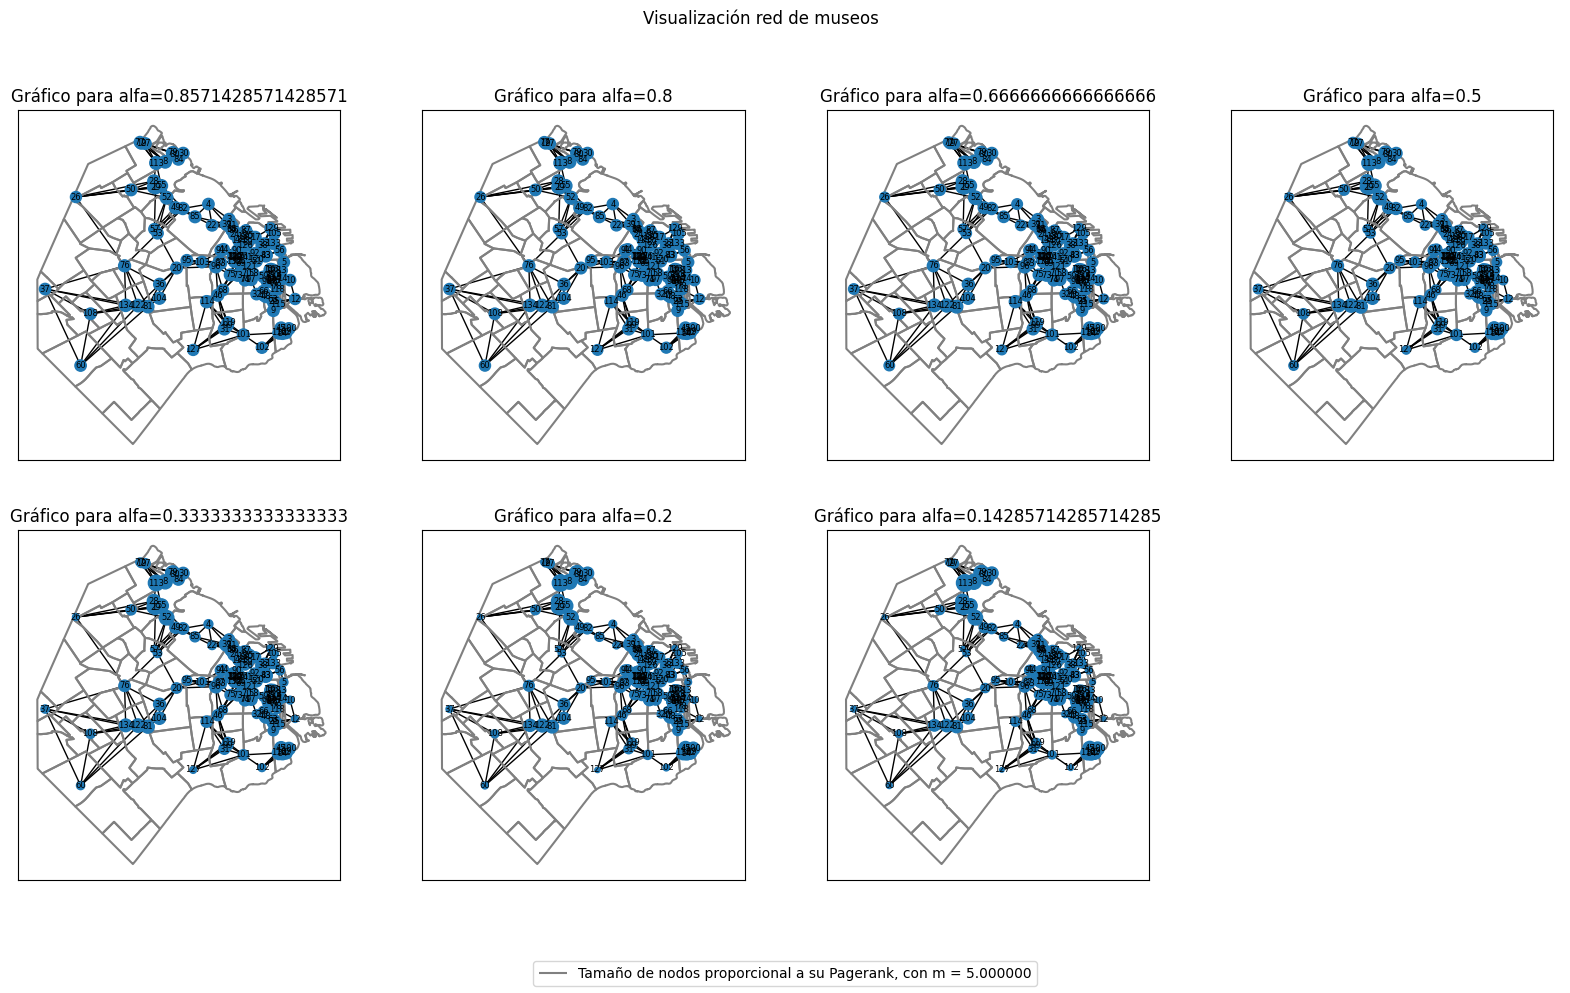

In [ ]:
#Punto 3 item c + visualizaciones pedidas en el segundo ítem b
alfas = [6/7,4/5,2/3,1/2,1/3,1/5,1/7]
m = 5

#Construcción matriz de adyacencia.
matriz = construye_adyacencia(D, m)

#La función recibe una matriz de adyacencia y un factor de amortiguamiento
#Calcula los Page Rank para cada factor de amortiguamiento solicitado
puntaje_c1 = calcula_pagerank(matriz, 6/7)
puntaje_c2 = calcula_pagerank(matriz, 4/5)
puntaje_c3 = calcula_pagerank(matriz, 2/3)
puntaje_c4 = calcula_pagerank(matriz, 1/2)
puntaje_c5 = calcula_pagerank(matriz, 1/3)
puntaje_c6 = calcula_pagerank(matriz, 1/5)
puntaje_c7 = calcula_pagerank(matriz, 1/7)

#Si se desea visualizar los Page Rank obtenidos de los museos en cada caso, se recomienda el uso de la función mostrar_pagerank, implementada en el template_funciones.py
#mostrar_pagerank(puntaje_c1)
#mostrar_pagerank(puntaje_c2)
#mostrar_pagerank(puntaje_c3)
#mostrar_pagerank(puntaje_c4)
#mostrar_pagerank(puntaje_c5)
#mostrar_pagerank(puntaje_c6)
#mostrar_pagerank(puntaje_c7)


"""Red de museos, donde cada uno se conecta con sus m = 5 vecinos mas cercanos, y considerando los
valores de factor de amortiguamiento α = 6/7, 4/5, 2/3, 1/2, 1/3, 1/5, 1/7"""
agrupar_graficos_variacion_alfa(m, alfas)

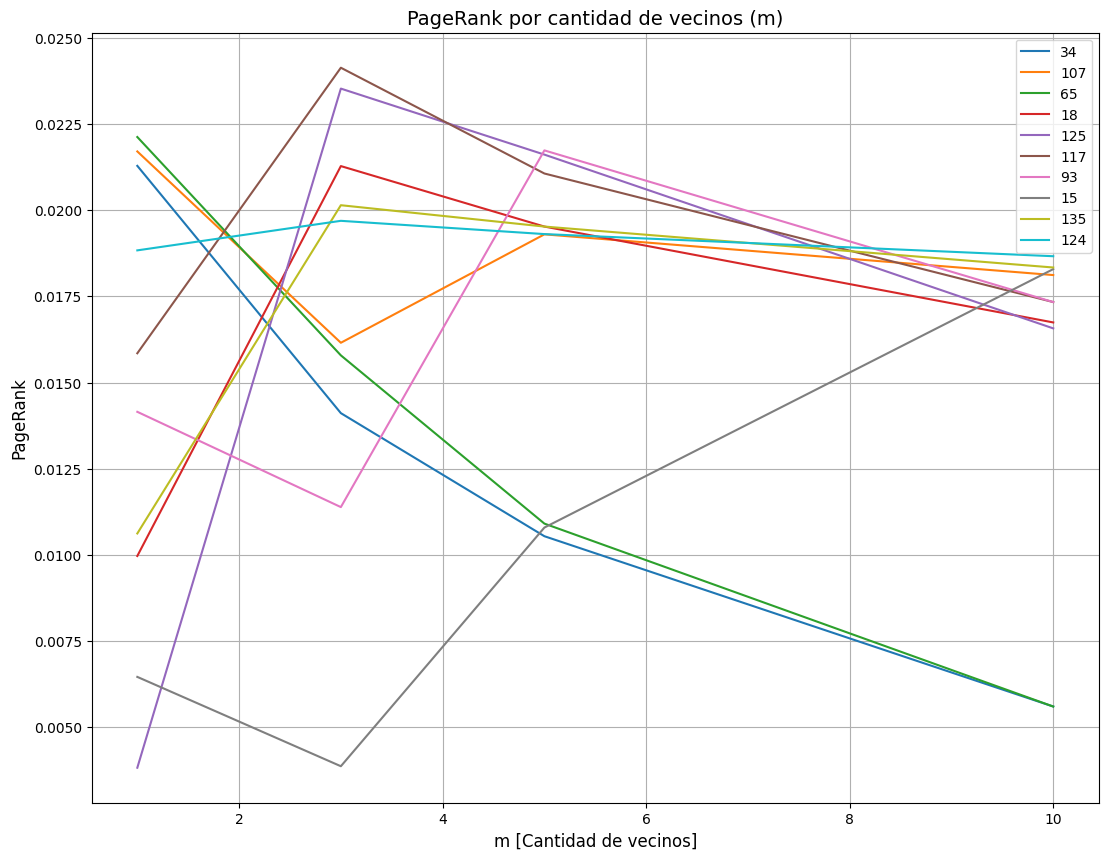

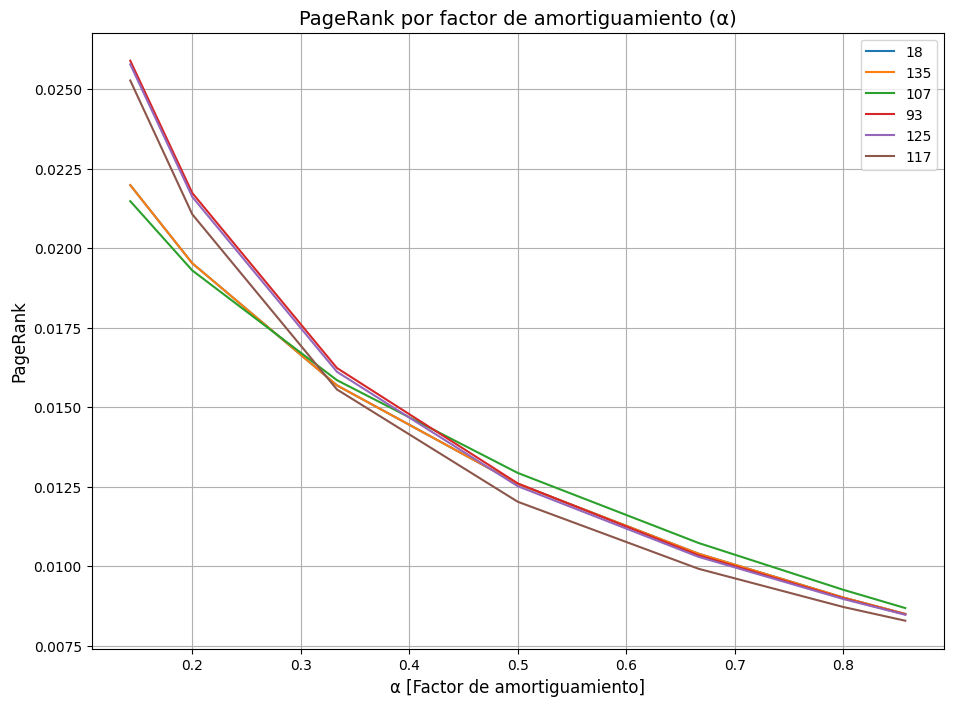

In [ ]:
#Punto 3 segundo ítem a
M_values = [1,3,5,10]
alfa = 1/5
#La siguiente función recibe una lista de m (cantidad de enlaces) y un único α (factor de amortiguamiento).
#Agrupa los tres museos centrales para cada m y realiza un lineplot que muestra la variación de su pagerank.
graficos_pagerank_por_m(M_values, alfa)


#La siguiente función recibe una lista de alfas (α, factor de amortiguamiento) y un único m (cantidad de enlaces).
#Agrupa los tres museos centrales para cada α y realiza un lineplot que muestra la variación de su pagerank.
alfa_values = [6/7,4/5,2/3,1/2,1/3,1/5,1/7]
m = 5
graficos_pagerank_por_alfa(m, alfa_values)


# **Análisis General** (segundos ítems a y b)



Luego de haber realizado las visualizaciones del mapa utilizando el Page Rank para representar el tamaño de cada museo, los resultados arrojados por los gráficos de museos centrales en los casos solicitados; y analizando la información hallada en los puntajes calculados, se obtuvo que:

Por un lado, al utilizar los distintos valores de $m$ (cantidad de vecinos más cercanos) que fueron considerados, esto es, $m = 1, 3, 5, 10$; junto con $α$ (factor de amortiguamiento) fijo, cuyo valor es de **1/5**; los museos que obtuvieron mayor Page Rank en cada caso fueron:

*   $m = 1$ : (**65**, 0.022124183006535954), (**107**, 0.021705882352941182), (**34**, 0.02128758169934641
*   $m = 3$ : (**117**, 0.024135005552429513), (**125**, 0.02352939704405662), (**18**, 0.021280854967728868)
*   $m = 5$ : (**93**, 0.021736255894120298), (**125**, 0.02161401652537472), (**117**, 0.021065661658928064)
*   $m = 10$ : (**124**, 0.01866544381551542), (**135**, 0.01833819870655664), (**15**, 0.01829068085587275)

Más en detalle, se puede ver que, cuando se busca los 3 vecinos más cercanos, los resultados de Page Rank de ciertos museos alcanzan valores mayores que en otros casos (hasta un 2.4% de Page Rank para el museo 117), lo que genera que probablemente haya mayor contraste en el tamaño de los nodos al momento de graficar. Luego, al aumentar $m$, los valores de Page Rank de los museos convergen a un mismo número.

\

Análogamente, también se analizó en detalle qué ocurre al variar los valores de $α$, que son  $α = [6/7,4/5,2/3,1/2,1/3,1/5,1/7]$, teniendo en este caso a un $m$ fijo, $m = 5$. Aquellos que obtuvieron mayor Page Rank en cada caso fueron:

*   $α = 6/7$ : (**107**, 0.008680522669439764), (**135**, 0.008495864796563618), (**18**, 0.008495864796563616)
*   $α = 4/5$ : (**107**, 0.009255573843367027), (**18**, 0.009012675802001865), (**135**, 0.009012675802001865)
*   $α = 2/3$ : (**107**, 0.010726921027230841), (**18**, 0.010390168197539571), (**135**, 0.01039016819753957)
*   $α = 1/2$ : (**107**, 0.012930502796005322), (**93**, 0.012601279856066122), (**135**, 0.012585386137257223)
*   $α = 1/3$ : (**93**, 0.016230380890655854), (**125**, 0.016112373613018482), (**107**, 0.015848311223301628)
*   $α = 1/5$ : (**93**, 0.021736255894120298), (**125**, 0.02161401652537472), (**117**, 0.021065661658928064)
*   $α = 1/7$ : (**93**, 0.025896005811955315), (**125**, 0.025781082435200862), (**117**, 0.02527389536044914)

En esta situación, se observa que, si $m$ está fijo, los museos que poseen mayor Page Rank suelen ser similares (se presenta una estabilidad en cuanto al ranking de museos con mayor puntaje), lo que significa que el factor de amortiguamiento no provoca un drástico cambio con respecto al Page Rank que cada museo obtuvo. Por otro lado, un detalle no menor es que, al aumentar el valor de $α$, el resultado alcanzado por cada museo es menor, es decir, el Page Rank hallado para cada museo tiende a ser 0 a medida que el factor de amortiguamiento aumenta.

\

Por lo tanto, luego de visualizar en los gráficos aquellos museos que fueron centrales en cada caso, se puede apreciar a simple vista que, para los valores de $m$ y $α$ utilizados, los museos que obtuvieron mayor Page Rank fueron aquellos que se encuentran en las regiones más céntricas/polos más concentrados de C.A.B.A., es decir, las regiones en donde hay mayor aglomeración de museos en la Ciudad.


## Punto 4:

$C$ está definida como la **matriz de transiciones**. Esto significa que $C_{ji}$ representa la probabilidad de moverse al museo $j$ luego de haber visitado el $i$ (exceptuando caso $j=i$ pues partimos de la base de que el caminante no puede moverse del museo $i$ al $i$ nuevamente, y por lo tanto $C_{ii}$ = 0).

Es por este motivo que, al considerar al vector $v_0 \in \mathbb{K}^n$, el cual representa la distribución de museos que son la primer visita de los visitantes, y que tiene en su elemento $i$ la cantidad de visitantes que tienen al museo $i$ como su primer opción, entonces $v_1 = Cv_0$ representa al número de visitantes estimado que tendrá cada museo $i$ en el siguiente paso (donde cada paso/instancia la describimos como $k$, con $k \geq 0$ pues de lo contrario el sistema nunca habría comenzado).

Siguiendo esta lógica, $v_2 = Cv_1 = CCv_0 = C^2v_0$, es decir que cada instancia $k$ estará dada por la matriz $C^k$ (que describe la probabilidad de ir del museo $i$ al museo $j$ luego de $k$ pasos) en conjunto con $v_{0}$ que describe la cantidad de gente que había en cada museo $i$ al comienzo del sistema.  

En definitiva, esto se reduce a $v_k = C^kv_0$.

Ahora bien, si queremos hacer el cálculo estimado de cuántas personas visitaron cierto museo $i$ después de que cada persona de nuestro sistema incial realizara $r$ visitas antes de abandonar el sistema, eso se traduce en hacer la suma de cada vector $v_{0,..,r-1}\ , $ o en otras palabras, sumar la cantidad de gente que se estimó que había en el museo $i$ para cada paso/ronda que se dió (Nota: tomamos la instancia asociada a la primer visita como la número 0, de ahí la razón de ser de los subíndices del vector). Matemáticamente, si llamamos al vector $w \in \mathbb{K}^n$ aquel que describe en cada $w_i$  el número total de visitantes que se recibieron en el museo $i$ al finalizar el sistema, entonces luego $w_i = \sum_{k=0}^{r-1} v_{k_{i}} \quad$ (o, en su conjunto, $w = \sum_{k=0}^{r-1} v_k$).

Si desglosamos cada $v_k$, tenemos que $v_0 = C^0v_0 = v_0, \ v_1 = C^1v_0, \ ... \ , \ v_{r-1} = C^{r-1}v_0$.  Por lo tanto, esto implica que:

$w = \sum_{k = 0}^{r-1}C^kv_0 = (\sum_{k = 0}^{r-1}C^k) \ v_0 \quad $ pues $v_0$ no varía en función de $k$.

Si llamamos $B = \sum_{k = 0}^{r-1}C^k $, entonces $w = B \ v_0$

Es por eso que, finalmente, como $B$ se puede suponer inversible, y llamando $v$ a $v_0$ conseguimos:

$v = B^{-1}w \quad$ como se quería probar

$\hspace{15cm} \huge \boxtimes$

## Punto 5:

In [ ]:
# La siguiente función genera la matriz de transiciones definida en la ecuación (4) del PDF
C_continua = calcula_matriz_C_continua(D)

# Calcula la matriz B a partir de la nueva matriz de transiciones C y el número de pasos (r)
# Retorna la matriz B de la ecuación (5) del PDF
r = 3
B = calcula_B(C_continua, r)

# La siguiente función toma como parámetros la matriz B y el vector w
# Función que resuelve la ecuación (5) del PDF
# Retorna el vector v definido en el punto anterior
v = resolver_sist(B)

Para obtener la cantidad total de los visitantes que había al inicio del sistema, lo que buscamos resolver es la ecuación $Bv = w$. \
Para ello, programamos una función que calcule la matriz $B$ tal como fue descripta; y, al ser inversible, aprovechamos su descomposición $LU$ para resolver los sistemas: \
$Ly =w$ \
$Uv = y$

De esta manera, logramos hallar al vector $v$ que, como explicamos, en cada $v_i$ almacena la cantidad de visitantes que, al iniciar el sistema, se hallaron en el museo $i$. Luego, si nosotros queremos conocer la cantidad total inicial de visitantes, eso equivale a sumar cada $v_i$ (el cual, al tratarse de una cantidad de personas, es positivo o nulo); en definitiva, calcular $||v||_1$. Es por eso que, finalmente:

$||v||_1 = \text{calcular_norma_1}(v)$ \
$ ||v||_1 = 136605$ \

(Nota: $||v||_1$ la redondeamos pues se trata de una cantidad de personas).

In [ ]:
# Función que recibe un vector y calcula su norma_1
calcular_norma_1(v)

La norma 1 del vector v ingresado es: 136605.0


## Punto 6:

In [ ]:
# La siguiente función calcula el número de condición de una matriz.
# Toma como parámetro la matriz al cual se le interesa hallar su número de condición.
# Para esto, la matriz ingresada debe ser inversible.
Cond_1_B = condicion_1_B(B)
print(f'El número de condición_1 de la matriz B ingresada es: {Cond_1_B}')


El número de condición_1 de la matriz B ingresada es: 5.051771176665007


Sea el error relativo de la cantidad total final de visitantes un $5 \% $ ($\frac{||w - \tilde{w}||_1}{||w||_1} = 0.05$).

Y sea, $B = \sum_{k = 0}^{2}C^k $ pues tengo $r$ = cantidad de visitas = 3.

Entonces luego, se puede acotar el error relativo de la cantidad inicial de personas al inicio del sistema como:

$\frac{||v - \tilde{v} ||_1}{||v||_1} \leq Cond_1(B)  \frac{||w - \tilde{w} ||_1}{||w||_1}$

\

Ahora, para calcular $Cond_1(B) = ||B||_1||B^{-1}||_1$, utilizamos nuestra función `condicion_1_B`, el cual arroja que $Cond_1(B) = 5.051771176665007$

Podemos acotar superiormente el error de estimación de $v$ por $e_{\frac{||v - \tilde{v} ||_1}{||v||_1}} \sim 0.2526$

\

Finalmente, $\frac{||v - \tilde{v} ||_1}{||v||_1} \leq Cond_1(B)  \frac{||w - \tilde{w} ||_1}{||w||_1} \sim 0.2526$

In [ ]:
error = Cond_1_B * 0.05
print(f'El error de estimación de v se puede acotar por {error}')

El error de estimación de v se puede acotar por 0.2525885588332503


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, '2'),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19

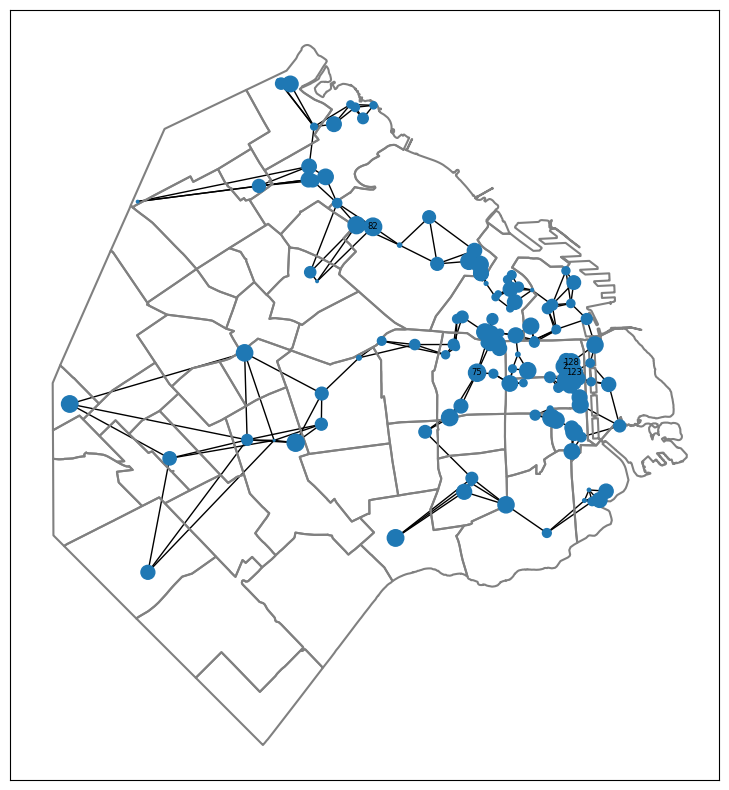

In [ ]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres